# CellProfiling  in Python

A high-throughput screening analysis pipeline, similar to what you would do in CellProfiler, implemented in Python.

Aims: 

* create an image analysis pipeline for batch processing, somewhat similar to running Cellprofiler
* do some statistical analysis and create interactive visualizations using holoviews
* introduce pandas data frames

# High Throughput Screening Workflow

<img src="./Illustrations/HTMPipeline_alt.png" height=800>

# Sample images
Images are a subset of dataset BBBC022 from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/)

The following description of the dataset is from their website (https://data.broadinstitute.org/bbbc/BBBC022/):

Description of the biological application
Phenotypic profiling attempts to summarize multiparametric, feature-based analysis of cellular phenotypes of each sample so that similarities between profiles reflect similarities between samples. This image set provides a basis for testing image-based profiling methods wrt. to their ability to distinguish the effects of small molecules.

Images
The images are of U2OS cells treated with each of 1600 known bioactive compounds and labeled with six labels that characterize seven organelles (the “Cell Painting” assay).

This pilot experiment consists of 20 plates. Each plate has 384 wells and each well has 9 fields of view for a total of 69,120 fields of view. Each field was imaged in five channels (detection wavelengths), and each channel is stored as a separate, grayscale image file, so there are 345,600 image files in 16-bit TIFF format.

The images are provided in 100 zip archive files, one for each combination of plate and channel. There is a list of the URLs of all 100 files to facilitate downloading the entire image set in batch.

In [2]:
# Import modules
import pathlib
import re
import numpy as np
import mahotas # see other Image Analysis Packages !
import scipy.ndimage.morphology
import pandas as pd
from skimage.io import imread
# Alternative
#from tifffile import imread

In [ ]:
#files = glob.glob("/Users/volker/Downloads/BroadData/**/*.tif", recursive=True)

## Dealing with filenames in python, the 2018 way 

Consider using `pathlib` instead of `os.path`.


In [7]:
# Set our base folder (adjust this to the path where your images are)
folder = pathlib.Path("/Users/volker/Downloads/BroadData/for_course/")
folder.rglob?

In [10]:
# rglob "recursive" (i.e. look in subfolders) "glob" (search for files) according to a pattern (here "*.tif")
files =  folder.rglob("*.tif")
files

<generator object Path.rglob at 0x1a1eb6ff68>

In [11]:
# But what is this thing ? Doesn't look like a list of filenames !
files

<generator object Path.rglob at 0x1a1eb6ff68>

It's a _generator_ object ... you will find these get returned quite often in Python 3 (also in places where you would have gotten back a list in python 2.7). 


You can convert the generator object into a list using `list()`. 

In [13]:
allfiles = list(files)
allfiles

[]

Now try to run the above cell again ... What's happening?

The generator generates each item only once !

So what is the benefit ?

**only compute when needed** 

In [20]:
#%%timeit
files =  folder.rglob("*.tif")
import itertools
first_5_files = itertools.islice(files, 5)
first_5_files = list(first_5_files)
first_5_files

[PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s2_w1AA6B1894-F561-42EE-9D1D-E21E5C741B75.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s1_w17C9F8BDB-79F0-4F8B-852B-71161631F236.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s2_w1D18DF60D-A77E-4A79-B823-CA9754A95240.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A03_s1_w1073D64AC-9B57-43E1-A34E-1C7C986DEEFA.tif')]

In [15]:
%%timeit 
files =  folder.rglob("*.tif")
first_5_files = list(files)[:5]
first_5_files

13.6 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Extracting Metadata from Path/File names with regular expressions

In many cases, you will find some Metadata that is related to your screen embedded in the file names of the images.
Therefore we need to extract this information from the images we analyze.

_Regular expressions_ are a flexible tool for analyzing/splitting strings that are built according to some regular pattern. If you google for "python regular expressions" you will find plenty of documentation and examples on how to use them. 

As regular expressions have a large number of building blocks that may be difficult to remember, it is nice to have a cheat sheet. There is a great online tool for creating and debugging regular expressions with a built-in cheat sheet, namely [regex101](http://regex101.com ). Make sure you select Python on the left.

<img src="./Illustrations/regex101.png" width=800>

In [21]:
# this regular expression should work, give it a try in regex101 
# you can also try and modify it so you extract well column and well row separately
regex = r"(?P<basepath>.*)[/\\].*images_(?P<Plate>.*)w\d[/\\](?P<Prefix>.*)_(?P<well>[A-Z]\d\d)_s(?P<subpos>\d)_w(?P<Channel>\d)(?P<ID>.*)\.tif$"
first_5_files

[PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s2_w1AA6B1894-F561-42EE-9D1D-E21E5C741B75.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s1_w17C9F8BDB-79F0-4F8B-852B-71161631F236.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s2_w1D18DF60D-A77E-4A79-B823-CA9754A95240.tif'),
 PosixPath('/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A03_s1_w1073D64AC-9B57-43E1-A34E-1C7C986DEEFA.tif')]

In [23]:
firstimage = str(first_5_files[0])
firstimage

'/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif'

In [48]:
import sys
sys.version
pd.__version__

'0.22.0'

In [27]:
m = re.match(regex, firstimage)
m.groupdict()["basepath"]

'/Users/volker/Downloads/BroadData/for_course'

In [28]:
tmp = m.groupdict()
tmp

{'basepath': '/Users/volker/Downloads/BroadData/for_course',
 'Plate': '20585',
 'Prefix': 'IXMtest',
 'well': 'A01',
 'subpos': '1',
 'Channel': '1',
 'ID': '64FBEEF7-F77C-4892-86F5-72D0160D4FB2'}

In [29]:
tmp["filename"] = firstimage
tmp

{'basepath': '/Users/volker/Downloads/BroadData/for_course',
 'Plate': '20585',
 'Prefix': 'IXMtest',
 'well': 'A01',
 'subpos': '1',
 'Channel': '1',
 'ID': '64FBEEF7-F77C-4892-86F5-72D0160D4FB2',
 'filename': '/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif'}

In [30]:
pd.Series(tmp) # convert the dictionary to a pd.Series

Channel                                                     1
ID                       64FBEEF7-F77C-4892-86F5-72D0160D4FB2
Plate                                                   20585
Prefix                                                IXMtest
basepath         /Users/volker/Downloads/BroadData/for_course
filename    /Users/volker/Downloads/BroadData/for_course/B...
subpos                                                      1
well                                                      A01
dtype: object

Let's assemble the individual steps we performed above into a single function.
Given a filename and a regular expression the function should extract metadata using the regular expression
and extract it. 

In [42]:
def get_metadata_as_series(filepath, regex, filename_key="filepath"):
    ''' 
    provided with a filepath (can be a string or a pathlib.PosixPath object),
    tries to match the path against the regular expression regex.
    The extracted keys, plus the filepath are returned as a pandas Series object
    '''
    filepath = str(filepath)
    m = re.match(regex, filepath)
    if m is not None:
        tmp = m.groupdict()
        tmp[filename_key] = filepath
        return pd.Series(tmp)
    else:
        print(f"Extracting metadata for {filepath} failed.")
        return None
    
get_metadata_as_series(firstimage, regex)

Channel                                                     1
ID                       64FBEEF7-F77C-4892-86F5-72D0160D4FB2
Plate                                                   20585
Prefix                                                IXMtest
basepath         /Users/volker/Downloads/BroadData/for_course
filepath    /Users/volker/Downloads/BroadData/for_course/B...
subpos                                                      1
well                                                      A01
dtype: object

You can combine a list of multiple `pd.Series` objects into a `pd.DataFrame`. 

More on `DataFrames` later.

Let's try with two series:

In [43]:
s1 = get_metadata_as_series(first_5_files[1], regex)
s2 = get_metadata_as_series(first_5_files[2], regex)
print(s1, s2)

Channel                                                     1
ID                       AA6B1894-F561-42EE-9D1D-E21E5C741B75
Plate                                                   20585
Prefix                                                IXMtest
basepath         /Users/volker/Downloads/BroadData/for_course
filepath    /Users/volker/Downloads/BroadData/for_course/B...
subpos                                                      2
well                                                      A01
dtype: object Channel                                                     1
ID                       7C9F8BDB-79F0-4F8B-852B-71161631F236
Plate                                                   20585
Prefix                                                IXMtest
basepath         /Users/volker/Downloads/BroadData/for_course
filepath    /Users/volker/Downloads/BroadData/for_course/B...
subpos                                                      1
well                                                    

In [44]:
pd.DataFrame([s1, s2])

Channel                                    ID  Plate   Prefix  \
0       1  AA6B1894-F561-42EE-9D1D-E21E5C741B75  20585  IXMtest   
1       1  7C9F8BDB-79F0-4F8B-852B-71161631F236  20585  IXMtest   

                                       basepath  \
0  /Users/volker/Downloads/BroadData/for_course   
1  /Users/volker/Downloads/BroadData/for_course   

                                            filepath subpos well  
0  /Users/volker/Downloads/BroadData/for_course/B...      2  A01  
1  /Users/volker/Downloads/BroadData/for_course/B...      1  A02

# Find all files and extract metadata

Now let's create a data frame by analyzing all the filenames. 
There are several ways to do this: 
* You could use a for loop 
* You can use a `list comprehension`
* You can use `map`


In [51]:
# create a fresh generator, because we've "used up" the previous one
files =  folder.rglob("*.tif") 
# for each file, extract the metadata ... using a list comprehension
#metadata_series_list = []
#for f in files:
#    metadata_series_list.append(get_metadata_as_series(f, regex))
metadata_series_list = [get_metadata_as_series(f, regex) for f in files]
metadata_series_list

[Channel                                                     1
 ID                       64FBEEF7-F77C-4892-86F5-72D0160D4FB2
 Plate                                                   20585
 Prefix                                                IXMtest
 basepath         /Users/volker/Downloads/BroadData/for_course
 filepath    /Users/volker/Downloads/BroadData/for_course/B...
 subpos                                                      1
 well                                                      A01
 dtype: object, Channel                                                     1
 ID                       AA6B1894-F561-42EE-9D1D-E21E5C741B75
 Plate                                                   20585
 Prefix                                                IXMtest
 basepath         /Users/volker/Downloads/BroadData/for_course
 filepath    /Users/volker/Downloads/BroadData/for_course/B...
 subpos                                                      2
 well                                   

Now combine all metadata series objects into a **pandas** `DataFrame`

In [52]:
# there are many ways to create a DataFrame. Here we pass a list of pd.Series objects
df_meta = pd.DataFrame(metadata_series_list)

Just evaluating a pandas DataFrame in a cell will provide a tabular output (abbreviated for long data frames)

In [53]:
df_meta

Channel                                    ID  Plate   Prefix  \
0          1  64FBEEF7-F77C-4892-86F5-72D0160D4FB2  20585  IXMtest   
1          1  AA6B1894-F561-42EE-9D1D-E21E5C741B75  20585  IXMtest   
2          1  7C9F8BDB-79F0-4F8B-852B-71161631F236  20585  IXMtest   
3          1  D18DF60D-A77E-4A79-B823-CA9754A95240  20585  IXMtest   
4          1  073D64AC-9B57-43E1-A34E-1C7C986DEEFA  20585  IXMtest   
5          1  BDC8FBC3-3D12-4621-9BDB-F026F088DE31  20585  IXMtest   
6          1  95151D27-9F95-44DE-A514-2ED183E548C9  20585  IXMtest   
7          1  F4C65F6F-669F-47F6-9B12-41D7934E620E  20585  IXMtest   
8          1  B60A237D-AC88-48EE-B759-7B6B0795E975  20585  IXMtest   
9          1  22CA072D-10D8-4177-AA22-8440DA832D60  20585  IXMtest   
10         1  3139E5A6-DC5B-43A9-A647-A3BA99C99275  20585  IXMtest   
11         1  117A2E44-ED34-4F84-84CC-3AC8366D6B1E  20585  IXMtest   
12         1  CBAE8849-273C-4468-867F-2E4D0953B673  20585  IXMtest   
13         1  06CECEB0-1E15-4F3E-BAD1-398584D74318  20585  IXMtest   
14         1  E9F96FA5-12E0-4F74-9EA6-D91738F21EA0  20585  IXMtest   
15         1  81A8130C-9226-4479-9B0F-CB2DDFEC76F5  20585  IXMtest   
16         1  DBB2749A-F3DE-4BF6-B14B-960E62F29548  20585  IXMtest   
17         1  7055C5CB-EE4D-46C8-A326-EA43E4B312A7  20585  IXMtest   
18         1  88711377-3C26-4CD0-A077-41ABADC5DE62  20585  IXMtest   
19         1  F530E26B-2874-407E-91CC-6CF8A609E293  20585  IXMtest   
20         1  9A39BBA1-1393-41E6-A7A5-A56ED3A0D046  20585  IXMtest   
21         1  045204F4-CDB9-40B8-8CD9-E217F8B12519  20585  IXMtest   
22         1  372F05C0-79EE-409F-BE07-20AB2CD28DF8  20585  IXMtest   
23         1  5036592E-C279-4C59-838F-3F24DFBDAB39  20585  IXMtest   
24         1  B35C6D5D-DBF9-4779-990D-5E7AFB14D600  20585  IXMtest   
25         1  951890F6-3FBD-488D-A559-E437F411FE17  20585  IXMtest   
26         1  7AEAE43F-5F47-460C-B448-EA0EC1D7F987  20585  IXMtest   
27         1  4C64CFF3-8968-4802-9F75-2AA8075D7EFC  20585  IXMtest   
28         1  2BB3CEA6-3260-47BC-BAA8-3D76C7D912D0  20585  IXMtest   
29         1  BDE4C24D-E8BA-4D10-AA70-ABDAD4D1E091  20585  IXMtest   
...      ...                                   ...    ...      ...   
1890       5  498F29C3-5A45-4DA2-988D-875E6062E7C3  20590  IXMtest   
1891       5  0AF34D20-1032-43E6-A0D9-476C5EF7E284  20590  IXMtest   
1892       5  57ABC3FA-ADD7-4734-B44C-87DCFDAD6AD0  20590  IXMtest   
1893       5  7FF4B2B7-7DD7-404B-A5FA-2E5FC95E4163  20590  IXMtest   
1894       5  F9E6258E-BFCB-4075-AD38-0B1226282934  20590  IXMtest   
1895       5  4C2D7DD4-D534-4622-A304-249C6639C41F  20590  IXMtest   
1896       5  A9DC5182-EB8E-4A45-8B37-EBED5A1CC4CF  20590  IXMtest   
1897       5  FC615908-2554-4C9F-AB63-8C1C3DD9AAAE  20590  IXMtest   
1898       5  CB9DFC57-CF24-4A3A-AAE1-1B8DB146130E  20590  IXMtest   
1899       5  7AD00024-0CCF-499C-ABCE-94CF745EC741  20590  IXMtest   
1900       5  766625BD-B2EE-48B4-90C8-7FC705451D93  20590  IXMtest   
1901       5  22418318-44BE-4052-856E-9057AB7DBE30  20590  IXMtest   
1902       5  F55E8338-BCFC-4222-B748-60809481F292  20590  IXMtest   
1903       5  3D7F6E14-7E8E-4BF3-90F9-CAAB8523247D  20590  IXMtest   
1904       5  F1A799A3-22D8-4686-AF53-9F1385560D2C  20590  IXMtest   
1905       5  BFB1EF87-DE59-4AEF-94B7-E29D80DFA2A6  20590  IXMtest   
1906       5  0D84087D-9CC1-4724-800E-0A7CAEF437B0  20590  IXMtest   
1907       5  908996D8-0109-4F77-A17B-B5DD106DB52A  20590  IXMtest   
1908       5  C03F78C8-5217-4CD4-BB36-56200ABAC72F  20590  IXMtest   
1909       5  85FE2754-046A-44F7-ACDF-98830B59446A  20590  IXMtest   
1910       5  A4D54B4C-D331-4266-B370-C9CF1F9385D6  20590  IXMtest   
1911       5  E7953B52-64CF-43A4-8C95-A2B96477CCFB  20590  IXMtest   
1912       5  7C18AB93-1D39-469D-9536-3B69D5315E1E  20590  IXMtest   
1913       5  12FFF0DD-5479-40F2-847E-CD6201AC90B5  20590  IXMtest   
1914       5  761216F4-2FBF-4372-A43A-C2C531D0AF30  20590  IXMtest   
1915       5  B

You can get some summary information for the data frame using `.describe()`

In [55]:
df_meta.describe()

Channel                                    ID  Plate   Prefix  \
count     1920                                  1920   1920     1920   
unique       5                                  1920      2        1   
top          1  8328CA49-B2B6-41FF-B757-379787D743F9  20585  IXMtest   
freq       384                                     1   1200     1920   

                                            basepath  \
count                                           1920   
unique                                             1   
top     /Users/volker/Downloads/BroadData/for_course   
freq                                            1920   

                                                 filepath subpos  well  
count                                                1920   1920  1920  
unique                                               1920      2   120  
top     /Users/volker/Downloads/BroadData/for_course/B...      1   A13  
freq                                                    1    960    20

If you just want to get a quick feel for what kind of data is in a data frame, but you don't want to output a long frame use `.head()`

In [56]:
df_meta.head()

Channel                                    ID  Plate   Prefix  \
0       1  64FBEEF7-F77C-4892-86F5-72D0160D4FB2  20585  IXMtest   
1       1  AA6B1894-F561-42EE-9D1D-E21E5C741B75  20585  IXMtest   
2       1  7C9F8BDB-79F0-4F8B-852B-71161631F236  20585  IXMtest   
3       1  D18DF60D-A77E-4A79-B823-CA9754A95240  20585  IXMtest   
4       1  073D64AC-9B57-43E1-A34E-1C7C986DEEFA  20585  IXMtest   

                                       basepath  \
0  /Users/volker/Downloads/BroadData/for_course   
1  /Users/volker/Downloads/BroadData/for_course   
2  /Users/volker/Downloads/BroadData/for_course   
3  /Users/volker/Downloads/BroadData/for_course   
4  /Users/volker/Downloads/BroadData/for_course   

                                            filepath subpos well  
0  /Users/volker/Downloads/BroadData/for_course/B...      1  A01  
1  /Users/volker/Downloads/BroadData/for_course/B...      2  A01  
2  /Users/volker/Downloads/BroadData/for_course/B...      1  A02  
3  /Users/volker/Downloads/BroadData/for_course/B...      2  A02  
4  /Users/volker/Downloads/BroadData/for_course/B...      1  A03

### Interactive, sortable display of data frames using qgrid

Notice how we only get a static, abbreviated output of the large data frame in the notebook.
You can also display the dataframe in an interactive fashion using the qgrid package. To install, run
```
conda install -c conda-forge qgrid 
```
Documentation and examples can be found at https://github.com/quantopian/qgrid

In [57]:
import qgrid
tablewidget = qgrid.show_grid(df_meta, show_toolbar=True)
tablewidget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8}, precision=5, show_toolbar=True)

You can actually edit the data frame with the qgrid widget and read back the contents into a data frame (see the documentatoin for details). 

This may be convenient, but from the perspective of reproducible data analysis such manual changes are not recommended unless you save your modified data frame, such that your changes can be reproduced from a file.


now we have already used `pd.Series` and `pd.DataFrame`, but ...

# ... what is Pandas ?
**Pandas** is a library that provides a `DataFrame` data structure and functions to work efficiently on this data structure. This is equivalent to a `DataFrame` or `tibble` in R. 
If you are not familiar with the concept of data frames, just think of it as an Excel table or a table in a relational database.

## How does a Pandas DataFrame differ from a numpy array ?
* `numpy` arrays are homogeneous, in the sense that they contain the same data type for each member of the array.
* `numpy` arrays support `n`-dimensional data, where `n` can be larger than 2.
* `pandas.DataFrame` objects can be heterogeneous, i.e. every column can hold a different object type. This includes non-numerical data.
* `pandas.DataFrame` objects are essentially 2-dimensional


## What do Pandas and numpy have in common ?

* they have similar interfaces for working with the data. For example, you can perform operation such as `some_array.mean()` or `some_array.unique()` etc.
* under the hood, a pandas dataframe uses numpy arrays to store the data


## Why bother?

You won't be storing images in pandas data frames, so why bother?

Typically, the aim of your image analysis is to go from images to measurements, e.g. a list of objects and measured features for these objects. Pandas data frames are ideal data structures for storing and analysing such lists. 
Pandas data frames support grouping operations (`groupby`) that let you efficiently run operations on certain subsets of the data, following the [Split-Apply-Combine Pattern](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf)
popularized by _Hadley Wickham_.
For instance if you have a data table that holds measurements taken in multiple plates of a high-throughput-screen you can quickly calculate statistics on a per-plate level if you group by plate. [You can find more examples in the pandas documentation](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

# Learning Pandas
There is not enough time to cover pandas in depth during this course. For an introduction from the ground up,
check out Jake VanDerPlas's [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook).
[Direct link to the pandas chapter](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.00-Introduction-to-Pandas.ipynb).

Alternatively there are also notebooks available for Wes McKinney's book [Python for Data Analysis](https://github.com/wesm/pydata-book). 
[Chapter 5 introduces Pandas](http://nbviewer.jupyter.org/github/pydata/pydata-book/blob/2nd-edition/ch05.ipynb)

In [58]:
df_meta.head()

Channel                                    ID  Plate   Prefix  \
0       1  64FBEEF7-F77C-4892-86F5-72D0160D4FB2  20585  IXMtest   
1       1  AA6B1894-F561-42EE-9D1D-E21E5C741B75  20585  IXMtest   
2       1  7C9F8BDB-79F0-4F8B-852B-71161631F236  20585  IXMtest   
3       1  D18DF60D-A77E-4A79-B823-CA9754A95240  20585  IXMtest   
4       1  073D64AC-9B57-43E1-A34E-1C7C986DEEFA  20585  IXMtest   

                                       basepath  \
0  /Users/volker/Downloads/BroadData/for_course   
1  /Users/volker/Downloads/BroadData/for_course   
2  /Users/volker/Downloads/BroadData/for_course   
3  /Users/volker/Downloads/BroadData/for_course   
4  /Users/volker/Downloads/BroadData/for_course   

                                            filepath subpos well  
0  /Users/volker/Downloads/BroadData/for_course/B...      1  A01  
1  /Users/volker/Downloads/BroadData/for_course/B...      2  A01  
2  /Users/volker/Downloads/BroadData/for_course/B...      1  A02  
3  /Users/volker/Downloads/BroadData/for_course/B...      2  A02  
4  /Users/volker/Downloads/BroadData/for_course/B...      1  A03

In [67]:
# Let's look which wells we have images from:
df_meta.to_numeric()

AttributeError: 'DataFrame' object has no attribute 'to_numeric'

In [69]:
# note: different way of referring to the column, an alternative to df_meta["subpos"]
df_meta["subpos"].unique()

array(['1', '2'], dtype=object)

Exporting/Importing a data frame

* `.csv` files
* `.json` files
* `pickle`, `hdf5`, `sql`

and system clipboard. 
You can try 
```
df_meta.to_clipboard()
```

and using paste in Excel. 
Or try copying something in Excel and running

```
pd.read_clipboard()
```

In [72]:
df_meta.to_csv("~/myfiles.csv")
! cat /Users/volker/myfiles.csv

,Channel,ID,Plate,Prefix,basepath,filepath,subpos,well
0,1,64FBEEF7-F77C-4892-86F5-72D0160D4FB2,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s1_w164FBEEF7-F77C-4892-86F5-72D0160D4FB2.tif,1,A01
1,1,AA6B1894-F561-42EE-9D1D-E21E5C741B75,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A01_s2_w1AA6B1894-F561-42EE-9D1D-E21E5C741B75.tif,2,A01
2,1,7C9F8BDB-79F0-4F8B-852B-71161631F236,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s1_w17C9F8BDB-79F0-4F8B-852B-71161631F236.tif,1,A02
3,1,D18DF60D-A77E-4A79-B823-CA9754A95240,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w1/IXMtest_A02_s2_w1D18DF60D-A77E-4A79-B823-CA9754A95240.tif,2,A02
4,1,0

1066,5,3B006B59-7845-4B6B-8C29-B26C22A10FBB,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w5/IXMtest_C06_s1_w53B006B59-7845-4B6B-8C29-B26C22A10FBB.tif,1,C06
1067,5,EA5DE77C-DB7B-4B08-9867-53CE7332944D,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w5/IXMtest_C06_s2_w5EA5DE77C-DB7B-4B08-9867-53CE7332944D.tif,2,C06
1068,5,5D5B2DA4-D46B-4851-8173-AE7367CA4952,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w5/IXMtest_C07_s1_w55D5B2DA4-D46B-4851-8173-AE7367CA4952.tif,1,C07
1069,5,B260344D-8B14-40C7-907F-AC62342C1DA3,20585,IXMtest,/Users/volker/Downloads/BroadData/for_course,/Users/volker/Downloads/BroadData/for_course/BBBC022_v1_images_20585w5/IXMtest_C07_s2_w5B260344D-8B14-40C7-907F-AC62342C1DA3.tif,2,C07
1070,5,2CD78A66-A163-4A21-8A9C-F43F1D2B3DC6,2058

In [75]:
# We don't really need the columns ID, Prefix and basepath for our further analysis, so let's get rid of them
df_meta.drop(columns=['ID', 'Prefix', 'basepath'], inplace=True)

ValueError: labels ['ID' 'Prefix' 'basepath'] not contained in axis

In [74]:
df_meta # or use qgrid.show_grid(df_meta) for a more fancy output

Channel  Plate                                           filepath subpos  \
0          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
1          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
2          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
3          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
4          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
5          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
6          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
7          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
8          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
9          1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
10         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
11         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
12         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
13         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
14         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
15         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
16         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
17         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
18         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
19         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
20         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
21         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
22         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
23         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
24         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
25         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
26         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
27         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
28         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
29         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
...      ...    ...                                                ...    ...   
1890       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1891       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1892       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1893       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1894       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1895       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1896       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1897       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1898       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1899       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1900       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1901       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1902       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1903       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1904       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1905       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1906       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1907       5  20590  /Users/volker/D

# DataFrame `groupby` method 

Our data frame has one row for each image file. However, some of these images clearly belong together, that is the images of the different fluorescence channels taken in the same _subposition_ of the same _well_ on the same _plate_.
Therefore we want to group these images together. This can be done naturally using the `groupby()` method of the pandas DataFrame. 

In [76]:
groupby = df_meta.groupby(["well", "subpos", "Plate"])
groupby

In [77]:
# one can iterate over groups
for group in groupby:
    print(group)

(('A01', '1', '20585'),     Channel  Plate                                           filepath subpos  \
0         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
240       2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
480       3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
720       4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
960       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

    well  
0    A01  
240  A01  
480  A01  
720  A01  
960  A01  )
(('A01', '1', '20590'),      Channel  Plate                                           filepath subpos  \
1200       1  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1344       2  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1488       3  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1632       4  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   

(('A15', '2', '20590'),      Channel  Plate                                           filepath subpos  \
1229       1  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1373       2  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1517       3  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1661       4  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1805       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   

     well  
1229  A15  
1373  A15  
1517  A15  
1661  A15  
1805  A15  )
(('A16', '1', '20585'),     Channel  Plate                                           filepath subpos  \
30        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
270       2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
510       3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
750       4  20585  /Users/volker/Downloads/BroadData/for_course/B...   

(('B06', '2', '20585'),      Channel  Plate                                           filepath subpos  \
59         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
299        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
539        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
779        4  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
1019       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   

     well  
59    B06  
299   B06  
539   B06  
779   B06  
1019  B06  )
(('B06', '2', '20590'),      Channel  Plate                                           filepath subpos  \
1259       1  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1403       2  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1547       3  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1691       4  20590  /Users/volker/Downloads/BroadData/for_course/B.

(('B21', '2', '20585'),      Channel  Plate                                           filepath subpos  \
89         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
329        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
569        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
809        4  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
1049       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   

     well  
89    B21  
329   B21  
569   B21  
809   B21  
1049  B21  )
(('B21', '2', '20590'),      Channel  Plate                                           filepath subpos  \
1289       1  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1433       2  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1577       3  20590  /Users/volker/Downloads/BroadData/for_course/B...      2   
1721       4  20590  /Users/volker/Downloads/BroadData/for_course/B.

(('C12', '1', '20590'),      Channel  Plate                                           filepath subpos  \
1318       1  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1462       2  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1606       3  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1750       4  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   
1894       5  20590  /Users/volker/Downloads/BroadData/for_course/B...      1   

     well  
1318  C12  
1462  C12  
1606  C12  
1750  C12  
1894  C12  )
(('C12', '2', '20585'),      Channel  Plate                                           filepath subpos  \
119        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
359        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
599        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
839        4  20585  /Users/volker/Downloads/BroadData/for_course/B.

(('D06', '1', '20585'),      Channel  Plate                                           filepath subpos  \
154        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
394        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
634        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
874        4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
1114       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

     well  
154   D06  
394   D06  
634   D06  
874   D06  
1114  D06  )
(('D06', '2', '20585'),      Channel  Plate                                           filepath subpos  \
155        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
395        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
635        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
875        4  20585  /Users/volker/Downloads/BroadData/for_course/B.

(('E11', '1', '20585'),      Channel  Plate                                           filepath subpos  \
212        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
452        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
692        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
932        4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
1172       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

     well  
212   E11  
452   E11  
692   E11  
932   E11  
1172  E11  )
(('E11', '2', '20585'),      Channel  Plate                                           filepath subpos  \
213        1  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
453        2  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
693        3  20585  /Users/volker/Downloads/BroadData/for_course/B...      2   
933        4  20585  /Users/volker/Downloads/BroadData/for_course/B.

In [78]:
# one can get the group keys
keys = groupby.groups.keys()
# show only the first few
list(keys)[:10]

[('A01', '1', '20585'),
 ('A01', '1', '20590'),
 ('A01', '2', '20585'),
 ('A01', '2', '20590'),
 ('A02', '1', '20585'),
 ('A02', '1', '20590'),
 ('A02', '2', '20585'),
 ('A02', '2', '20590'),
 ('A03', '1', '20585'),
 ('A03', '1', '20590')]

In [79]:
# access an individual group by key
groupby.get_group(list(keys)[0])

Channel  Plate                                           filepath subpos  \
0         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
240       2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
480       3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
720       4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
960       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

    well  
0    A01  
240  A01  
480  A01  
720  A01  
960  A01

In [80]:
# pick a group as an example, here is randomly chose the group with index 8
example_group = groupby.get_group(list(keys)[8])
example_group


Channel  Plate                                           filepath subpos  \
4         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
244       2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
484       3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
724       4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
964       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

    well  
4    A03  
244  A03  
484  A03  
724  A03  
964  A03

In [82]:
# these happen to be sorted, already but to make sure we can do                                  
example_group.sort_values("Channel", ascending=True) # also try ascending=False to see that it is actually sorting                                  
                                  

Channel  Plate                                           filepath subpos  \
4         1  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
244       2  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
484       3  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
724       4  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   
964       5  20585  /Users/volker/Downloads/BroadData/for_course/B...      1   

    well  
4    A03  
244  A03  
484  A03  
724  A03  
964  A03

In [83]:
# now just grab the filepaths
example_group.sort_values("Channel", ascending=True)["filepath"]

4      /Users/volker/Downloads/BroadData/for_course/B...
244    /Users/volker/Downloads/BroadData/for_course/B...
484    /Users/volker/Downloads/BroadData/for_course/B...
724    /Users/volker/Downloads/BroadData/for_course/B...
964    /Users/volker/Downloads/BroadData/for_course/B...
Name: filepath, dtype: object

In [85]:
# but this is still a series, lets turn it into a list
filelist = list(example_group.sort_values("Channel", ascending=True)["filepath"])
[imread(f) for f in filelist] 

[array([[143, 139, 146, ..., 138, 136, 139],
        [141, 147, 147, ..., 136, 146, 141],
        [146, 149, 153, ..., 138, 136, 140],
        ..., 
        [263, 232, 220, ..., 152, 155, 161],
        [214, 211, 198, ..., 150, 157, 148],
        [200, 199, 189, ..., 155, 155, 160]], dtype=uint16),
 array([[202, 201, 215, ..., 175, 177, 181],
        [201, 201, 191, ..., 177, 175, 188],
        [205, 202, 195, ..., 180, 187, 182],
        ..., 
        [486, 487, 478, ..., 339, 316, 303],
        [478, 479, 474, ..., 302, 325, 303],
        [571, 538, 467, ..., 295, 321, 321]], dtype=uint16),
 array([[156, 155, 158, ..., 146, 157, 143],
        [148, 157, 153, ..., 146, 143, 149],
        [159, 162, 163, ..., 154, 152, 148],
        ..., 
        [616, 643, 674, ..., 337, 308, 320],
        [577, 635, 710, ..., 327, 301, 331],
        [600, 678, 679, ..., 308, 342, 323]], dtype=uint16),
 array([[247, 252, 245, ..., 205, 219, 213],
        [247, 225, 254, ..., 210, 212, 207],
        [2

In [90]:
# now we can read all of these images very quickly using a list comprehension or a map
images = map(imread, filelist)

In [89]:
list(images)

[]

Images is a `map` object. Similarly to generators the mapping is only evaluated when it is needed. 
We can force the evaluation (in this case reading the images) by converting it to a list.

In [93]:
#images = list(images)
type(images[0])

numpy.ndarray

Let's convert the list of numpy arrays into an _n_-dimensional array (n=3)

In [96]:
all_in_one = np.array(images)
all_in_one.shape


ImportError: dlopen(/Users/volker/anaconda/lib/python3.6/site-packages/matplotlib/_png.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/volker/anaconda/lib/python3.6/site-packages/matplotlib/_png.cpython-36m-darwin.so
  Reason: Incompatible library version: _png.cpython-36m-darwin.so requires version 45.0.0 or later, but libpng16.16.dylib provides version 44.0.0

## Interactive plotting and image viewing using holoviews/bokeh

**Bokeh** is a plotting library similar to `matplotlib`. However, instead of generating static plots it generates plots as HTML-files with Javascript that can be embedded in the notebook and allow user interaction.
**plot.ly **

**Seaborn**

**Holoviews** is a higher-level plotting library that can use **bokeh** and **matplotlib** as backened. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
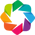

In [97]:
import holoviews as hv
hv.extension('bokeh')  # without speciyfing the extension you won't see a plot

In [106]:
imview = hv.Image(all_in_one[3,:,:]).options(tools=['hover'], cmap="gray",width=730, height=520, colorbar=True)
imview

:Image   [x,y]   (z)

With holoviews you can create an image viewer with a channel slider using their  `DynamicMap`.

In [102]:
def select_channel(c):
    tmp = all_in_one[c,: , :]
    size = tmp.shape
    return  hv.Image(tmp).options(tools=['hover'], cmap="gray", width=size[1], height=size[0])

hv.DynamicMap(select_channel, kdims=['c',]).redim.values(c=range(5))

:DynamicMap   [c]
   :Image   [x,y]   (z)

Now wrap this in a convenience function, so you can just run this on any image (note that in the cell above the callback  function referred directly to `all_in_one`)

In [103]:
def viewer_with_channel(image_ch):
    def select_ch(c):
        tmp = image_ch[c,: , :]
        size = tmp.shape
        return  hv.Image(tmp).options(tools=['hover'], cmap="gray", width=size[1], height=size[0])
    
    return(hv.DynamicMap(select_ch, kdims=['c',]).redim.values(c=range(image_ch.shape[0])))

In [104]:
viewer_with_channel(all_in_one)

:DynamicMap   [c]
   :Image   [x,y]   (z)

If you are keen, you can also try to add additional sliders for adjusting the range, the colormap etc.
Here is a rough cut piece of code that demonstrates this functionality:
https://github.com/VolkerH/my_hv_gallery/blob/master/Images_with_interactors/Dynamic_map_interactor.ipynb

# Build a simple image analysis pipeline

* missing: Preprocessing (noise removal, illumination correction, background subraction)
* Segment nuclei using OTSU
* Split and label nuclei
* Expand to find cytoplasm
* missing: remove touching objects


In [107]:
import skimage.filters # this module provides the otsu algorithm

Segment Nuclei using thresholding.
Determine the threshold value using Otsu's method of maximizing the inter-class variance. 
(https://en.wikipedia.org/wiki/Otsu's_method)

In [109]:
# TODO ... put the nuclear channel in im
im = all_in_one[0, : , :]
threshval = skimage.filters.threshold_otsu(im)
threshval
hv.Image(im>threshval)

:Image   [x,y]   (z)

In [110]:
hv.Image(im > threshval).options(cmap="gray",width=500, colorbar=True, tools=['hover'])

:Image   [x,y]   (z)

# Object splitting and connected component labelling

The following function takes a binary image and tries to split adjacent nuclei using the distance transform and finding local maxima.

In [118]:
def split_and_label(thresholded_image, bc_size = (9,9)):
    
    '''split objects using distance transform and watershed
    this implementation uses functions from the mahotas package
    
    You could also try to implement this using scikit-image and scipy.ndimage functions
    such as scipy.ndimage.morphology.distance_transform_edt for the distance transform
    and peak_local_max to find the regional maxima of the seed points
    see for example here: scipy.ndimage.morphology.distance_transform_edt
    ''' 
    distances = mahotas.stretch(mahotas.distance(thresholded_image)) # you could try using 
    Bc = np.ones(bc_size) 
    maxima = mahotas.morph.regmax(distances, Bc=Bc) # you could try adapting this to s
    spots, n_spots = mahotas.label(maxima, Bc=Bc)
    surface = (distances.max() - distances)
    areas = mahotas.cwatershed(surface, spots)
    areas *= thresholded_image
    return(areas)

In [123]:
# todo 

# try segmenting the nuclei using otsu and split and label

labelled = split_and_label(im > threshval, (20,20))
hv.Image(labelled).options(cmap="flag", tools=['hover'])

:Image   [x,y]   (z)

# Finding the cytoplasm

Once you have the nuclei as seed points, you can use several methods to grow these seed regions to find the surrounding cytoplasm. There are a number of commonly used techniques, for example, CellProfiler provides the following techniques:

* watershed
* seeded region growing
* distance-N

Unless you have a marker that clearly delineates the cell boundary or marks the whole cytoplasm, you should use distance-N, otherwise you might bias your results (interactive whiteboard: explain why).

In [124]:
def distanceN(labels_in, distance):
    '''
    Distance-N implementation 
    Taken/adapted from the CellProfiler source code for their IdentifySecondaryObjects
    module.
    
    The basic idea is that you have some seed labels (in the context 
    of cell profiling these will typically be cell nuclei) that you want 
    to grow by n pixels to give a mask for a larger object (the cytoplasm).
    
    If you were only dealing with a single seed object, you could simply dilate with 
    a suitably sized structuring element. However, in general you have multiple seed 
    points and you don't want to merge those. Distance N will grow up to N pixels without
    merging objects that are closer together than 2N. 
    ''' 
    
    tmp = scipy.ndimage.morphology.distance_transform_edt(labels_in == 0, return_indices = True)
    distances, (i,j) = tmp
    labels_out = np.zeros(labels_in.shape, int)
    dilate_mask = distances <= distance
    labels_out[dilate_mask] = labels_in[i[dilate_mask],j[dilate_mask]]
    return labels_out    

In [132]:
cytolabel = distanceN(labelled, 30)
hv.Image(cytolabel-labelled).options(cmap="flag", tools=['hover'], width=700,height=500)

:Image   [x,y]   (z)

# Feature extraction for the cell regions in each channel

**TODO:**

* Read the documentation of [`skimage.measure`](http://scikit-image.org/docs/dev/api/skimage.measure.html), in particular `regionprops`.
* Apply `regionprops` using a label image and a greyvalue image
* Try and make sense of the output
* assemble into a data frame
* save a crop or thumbnail for each segmented cell

In [98]:
hv.__version__

'1.10.4'

In [100]:
import bokeh
bokeh.__version__

'0.12.16'

In [ ]:
conda upgrade -c conda-forge holoviews